In [40]:
Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет,
для прогнозирования невыполнения долговых обязательств по текущему кредиту. 
Выполнить прогноз для примеров из тестового датасета.

Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

Метрика качества

F1-score (sklearn.metrics.f1_score)

Требования к решению

Целевая метрика

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

SyntaxError: invalid syntax (<ipython-input-40-395af8098043>, line 3)

### Построение модели классификации

1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов
11. Прогнозирование на тестовом датасете

Выполнить для тестового датасета те же этапы обработки и постронияния признаков
Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных
### Описание датасета

1. Home Ownership - домовладение
2. Annual Income - годовой доход
3. Years in current job - количество лет на текущем месте работы
4. Tax Liens - налоговые обременения
5. Number of Open Accounts - количество открытых счетов
6. Years of Credit History - количество лет кредитной истории
7. Maximum Open Credit - наибольший открытый кредит
8. umber of Credit Problems - количество проблем с кредитом
9. Months since last delinquent - количество месяцев с последней просрочки платежа
10. Bankruptcies - банкротства
11. Purpose - цель кредита
12. Term - срок кредита
13. Current Loan Amount - текущая сумма кредита
14. Current Credit Balance - текущий кредитный баланс
15. Monthly Debt - ежемесячный долг
16. Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:
# Загрузка библиотек
import numpy as np
import pandas as pd

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
import xgboost as xgb
import catboost as catb
import lightgbm as lgbm


In [2]:
import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [5]:
# Указываем путь к данным
DATASET_PATH_TRAIN = 'course_project_train.csv'
DATASET_PATH_TEST = 'course_project_test.csv'

course_project_test.csv
course_project_train.csv
training_project_data.csv

In [6]:
df_train = pd.read_csv(DATASET_PATH_TRAIN)


df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [7]:
def reduce_mem_usage(df):
##""" перебирать все столбцы фрейма данных и изменять тип данных для уменьшения использования памяти  """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Объем используемой памяти до оптимизации: {:.2f} MB'.format(start_mem))

    for col in df._get_numeric_data().columns:
        col_type = df[col].dtype

        c_min = df[col].min()
        c_max = df[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] =df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)  
        else:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)

    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Объем используемой памяти после оптимизации: {:.2f} MB'.format(end_mem))
    print('Уменьшено на - {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [8]:
#df_train = reduce_mem_usage(df_train)

In [9]:
df_test = pd.read_csv(DATASET_PATH_TEST)

df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [10]:
#df_test = reduce_mem_usage(df_test)

In [11]:
# Загрузка данных
df_train.shape

(7500, 17)

In [12]:
df_test.shape

(2500, 16)

In [13]:
print('В train строк данных:', df_train.shape)
print('В test строк данных:', df_test.shape)

В train строк данных: (7500, 17)
В test строк данных: (2500, 16)


In [14]:
df_train.shape[1] -1 == df_test.shape[1]

True

In [15]:
# Анализируем наличие незаполненных значениях
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

3 признака (Annual Income - годовой доход(20,76%), Months since last delinquent - количество месяцев с последней просрочки платежа (54,41%), Credit Score -  кредитная исория, связанные с охраной здоровья(20,76%) имеют пропуски данных

In [16]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

### Анализ целевой переменной¶
Обзор распределения

Выделение целевой переменной и групп признаков

In [17]:
TARGET_NAME = 'Credit Default'

TRAIN_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + TRAIN_FEATURE_NAMES)

In [18]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

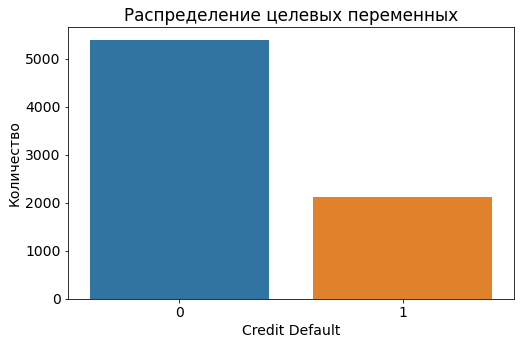

In [19]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)
plt.ylabel('Количество')
plt.xlabel('Credit Default')

plt.title('Распределение целевых переменных')
plt.show()

Обзор количественных признаков

In [20]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Обзор номинативных признаков

In [21]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '_' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
____________________________________________________________________________________________________

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
____________________________________________________________________________________________________

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

Корреляция с базовыми признаками

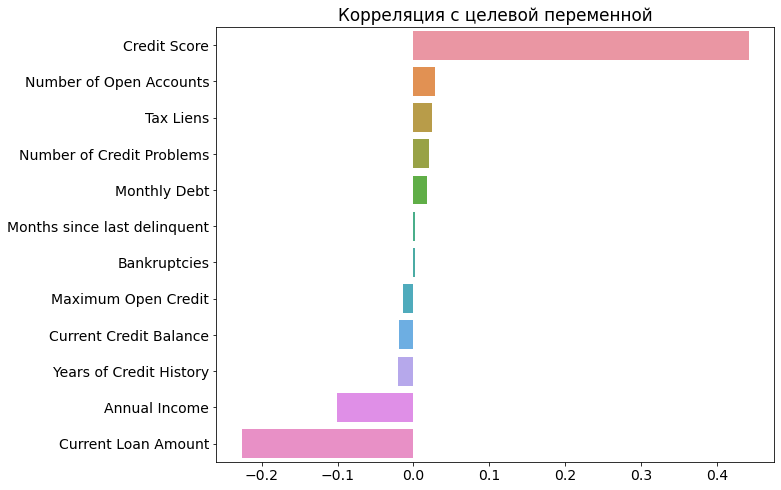

In [22]:
corr_with_target = df_train[TRAIN_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корреляция с целевой переменной')
plt.show()

Обработка пропусков

In [23]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [24]:
def mis_values_report(df): #Функция считает и выводит пропущенные значения столбцов датафрейма
    mis_val = df.isnull().sum()
    perc_mis_val = 100 * df.isnull().sum() / len(df)
    report = pd.concat([mis_val, perc_mis_val], axis=1)
    report_columns = report.rename(columns = {0: 'Количество пропусков', 1: '% пропусков'})
    report_columns = report_columns[report_columns.iloc[:,1] != 0].sort_values('% пропусков', ascending=False).round(2)
    print('Датафрейм имеет ' + str(df.shape[1]) + ' признаков\n' + 'в '+str(report_columns.shape[0]) + ' признаках имеются пропуски')
    return report_columns

In [25]:
mis_values_report(df_train)

Датафрейм имеет 17 признаков
в 5 признаках имеются пропуски


,Количество пропусков,% пропусков
Months since last delinquent,4081,54.41
Annual Income,1557,20.76
Credit Score,1557,20.76
Years in current job,371,4.95
Bankruptcies,14,0.19


#### Обработаем признак "Bankruptcies" имеет 0.19% пропусков (очень мало)

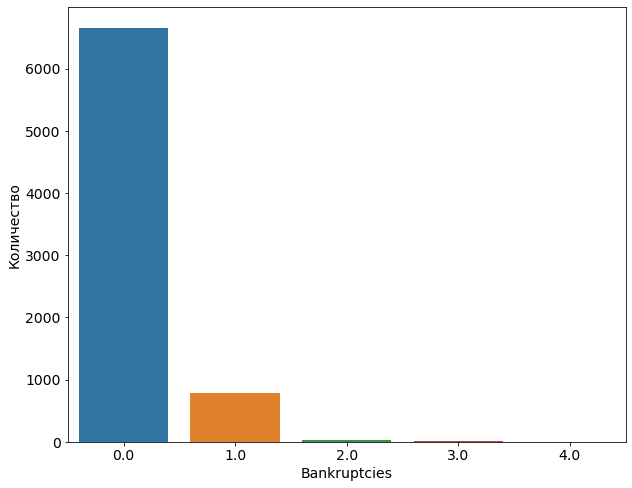

In [26]:
plt.figure(figsize=(10, 8))
sns.countplot(x='Bankruptcies', data=df_train)
plt.ylabel('Количество')
plt.xlabel('Bankruptcies')
plt.show()

In [27]:
# заменим пропущенные значения наиболее встречающиемся 
df_train['Bankruptcies'].fillna(float(0), inplace = True)

#### Обработаем признак "Years in current job" имеет 4.95% пропусков (мало)

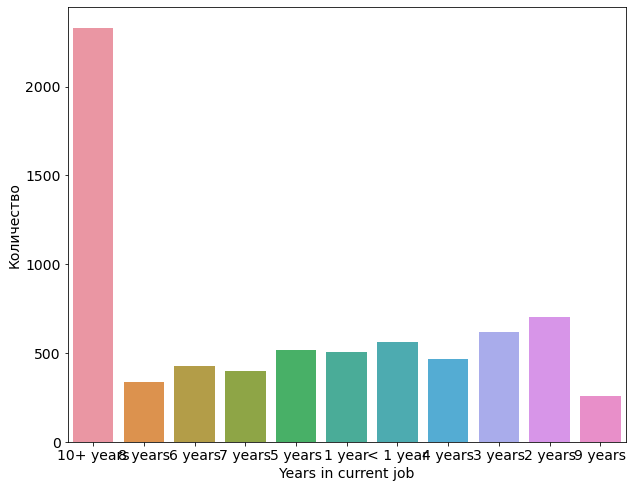

In [28]:
plt.figure(figsize=(10, 8))
sns.countplot(x='Years in current job', data=df_train)
plt.ylabel('Количество')
plt.xlabel('Years in current job')
plt.show()

In [29]:
# Заменяем пропускина наиболее встречающиемся 
df_train['Years in current job'].fillna('10+ years', inplace = True)

#### Обработаем признак "Credit Score" имеет 20.76% пропусков (много)

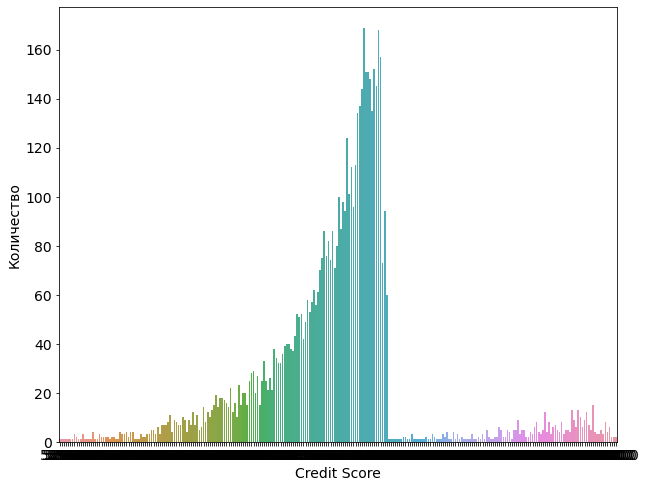

In [30]:
plt.figure(figsize=(10, 8))
sns.countplot(x='Credit Score', data=df_train)
plt.ylabel('Количество')
plt.xlabel('Credit Score')
plt.show()

<AxesSubplot:>

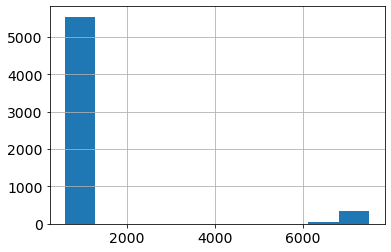

In [31]:
df_train['Credit Score'].hist() # более информативно

#### В признаке Credit Score присутствуют выбросы. Для заполнения пропусков медианой, поправим выбросы.

<AxesSubplot:xlabel='Credit Score'>

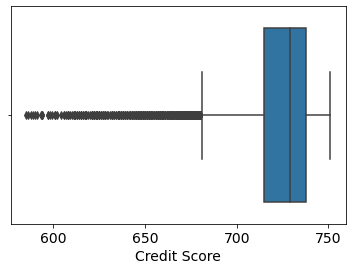

In [32]:
df_train['Credit Score'] = df_train['Credit Score'].apply(lambda val: (val / 10) if val>1000 else val)
df_train['Credit Score'].fillna(df_train['Credit Score'].median(), inplace=True)
sns.boxplot(x=df_train['Credit Score'])

#### Обработаем признак "Annual Income" имеет 20.76% пропусков (много)

In [33]:
#plt.figure(figsize=(10, 8))
#sns.countplot(x='Annual Income', data=df_train)
#plt.ylabel('Количество')
#plt.xlabel('Annual Income')
#plt.show()

<AxesSubplot:>

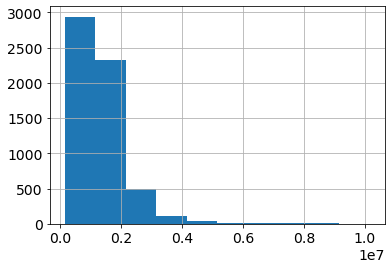

In [34]:
df_train['Annual Income'].hist() # более информативно

#### В признаке Credit Score присутствуют выбросы. Для заполнения пропусков медианой, поправим выбросы.

<AxesSubplot:xlabel='Annual Income'>

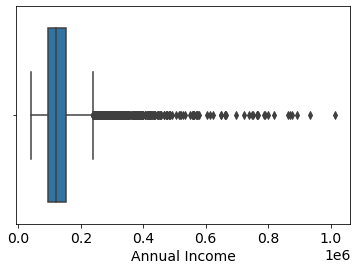

In [35]:
df_train['Annual Income'] = df_train['Annual Income'].apply(lambda val: (val / 10) if val>400000 else val)
df_train['Annual Income'].fillna(df_train['Annual Income'].median(), inplace=True)
sns.boxplot(x=df_train['Annual Income'])

In [36]:
# Удалим призник "Months since last delinquent", так как имеет 54.41% пропусков
df_train.drop(columns = 'Months since last delinquent', axis=1, inplace=True)

In [37]:
mis_values_report(df_train)

Датафрейм имеет 16 признаков
в 0 признаках имеются пропуски


,Количество пропусков,% пропусков


#### Приведение к катерагальным типам

In [38]:
df_train['Term'].replace(('Short Term','Long Term'),(0,1), inplace=True)

<AxesSubplot:xlabel='Credit Score', ylabel='count'>

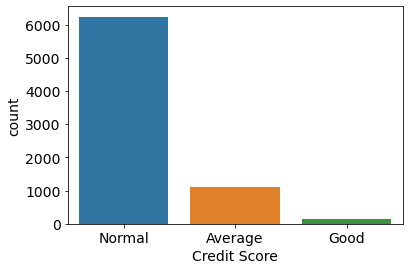

In [39]:
df_train['Credit Score'] = df_train['Credit Score'].apply(lambda val: "Average" if np.isreal(val) and val < 700 else val)
df_train['Credit Score'] = df_train['Credit Score'].apply(lambda val: "Normal" if np.isreal(val) and (val >= 700 and val < 750) else val)
df_train['Credit Score'] = df_train['Credit Score'].apply(lambda val: "Good" if np.isreal(val) and val >= 750 else val)
sns.countplot(df_train['Credit Score'])

In [40]:
# Преобразуем кредитный рейтинг в дискретные значения
df_get_dum=pd.get_dummies(df_train, columns=['Credit Score']).head()
df_train = pd.concat([df_train, df_get_dum], axis=1)

In [41]:
#df_train.head()

In [42]:
df_get_dum=pd.get_dummies(df_train, columns=['Home Ownership']).head()
df_train = pd.concat([df_train, df_get_dum], axis=1)

In [43]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,...,Credit Score_Average,Credit Score_Good,Credit Score_Normal,Home Ownership_Have Mortgage,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent
0,Own Home,48208.7,10+ years,0.0,11.0,26.3,685960.0,1.0,1.0,debt consolidation,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,Own Home,102548.7,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,debt consolidation,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,Home Mortgage,75141.2,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,debt consolidation,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,Own Home,80506.8,6 years,0.0,8.0,22.5,147400.0,1.0,1.0,debt consolidation,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,Rent,77626.4,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,debt consolidation,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [44]:
df_get_dum=pd.get_dummies(df_train, columns=['Purpose']).head()
df_train = pd.concat([df_train, df_get_dum], axis=1)
#df_train['Purpose'].value_counts().sort_values(ascending=True).plot(kind='barh', title='Purpose', figsize=(10,6))

In [45]:
df_get_dum=pd.get_dummies(df_train, columns=['Years in current job']).head()
df_train = pd.concat([df_train, df_get_dum], axis=1)

In [46]:
#df_train.head()

In [47]:
#df_train = df.drop(['Purpose'], axis=1)
#df_train = df.drop(['Years in current job'], axis=1)
#df_train = df.drop(['Home Ownership'], axis=1)
#df_train = df.drop(['Credit Score'], axis=1)

In [48]:
df_get_dum=pd.get_dummies(df_train, columns=['Number of Credit Problems']).head()
df_train = pd.concat([df_train, df_get_dum], axis=1)

In [49]:
#df_train.head()

In [50]:
target = df_train['Credit Default'].copy() 
features = df_train.drop(columns='Credit Default')


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6000, 678)
(1500, 678)
(6000, 32)
(1500, 32)


In [51]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

ValueError: y should be a 1d array, got an array of shape (6000, 32) instead.

In [ ]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

 

In [ ]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)